In [30]:
import sys
sys.path.append('../code')
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import neo
import pandas as pd
from externals.SpectralEvents import spectralevents as se

import mocap_functions, spike_train_functions, lfp_functions
from functools import partial
import pickle
import quantities as pq
import simnets
from sklearn.cluster import KMeans


In [2]:
experiment_dict = sio.loadmat('../data/SPK20220308/task_data/eventsCB1_corrected2.mat')
ev_ex = experiment_dict['eventsCB1']

tgtON = ev_ex['tgtON_C'][0][0][0]
gocON = ev_ex['gocON_C'][0][0][0]
stmv = ev_ex['stmv_C'][0][0][0]
endhold = ev_ex['endhold_C'][0][0][0]

downsample_rate = 30
samp_freq = 1000

#Use neo module to load blackrock files
fpath = '../data/SPK20220308/task_data/SPKRH20220308_CB1_quiver4toyPKPK4Rotation_delay_001'
lfp_data_raw, lfp_times_raw = lfp_functions.load_ns6_analog(fpath, downsample_rate, from_ns6=False, save=False, channel_step=2)

In [3]:
# read python dict back from the file
cb_dict_file = open('../data/SPK20220308/task_data/cb_dict.pkl', 'rb')
cb_dict = pickle.load(cb_dict_file)
cb_dict_file.close()

In [35]:
# Find scale/timeshift between CB1 and CB2
cb2_align_ts = cb_dict['cb2']['experiment_dict']['df']['gocON_C'][0][0][0]
assert len(cb2_align_ts) == len(gocON) 
cb2_start, cb2_end = cb2_align_ts[0], cb2_align_ts[-1]

ts_shift = gocON[0] - cb2_start 
ts_scale = (cb2_end - cb2_start) / (gocON[-1] -  gocON[0])

unit_timestamps = cb_dict['cb1']['unit_timestamps'].copy()

# Shift and scale time stamps between the two machines
unit_timestamps_cb2 = cb_dict['cb2']['unit_timestamps'].copy()
unit_timestamps_cb2_corrected = dict()
for unit_idx, unit_ts in unit_timestamps_cb2.items():
    ts_corrected = (unit_ts + ts_shift * (pq.s)) / (ts_scale)
    unit_timestamps_cb2_corrected[unit_idx] = ts_corrected


unit_timestamps.update(unit_timestamps_cb2_corrected)
unit_timestamps_list = [ts for ts in unit_timestamps.values()]


In [36]:
unit_timestamps_list

[array([4.08333333e-02, 9.77000000e-02, 2.51966667e-01, ...,
        4.13089153e+03, 4.13095137e+03, 4.13099620e+03]) * s,
 array([2.73000000e-02, 2.15266667e-01, 3.17800000e-01, ...,
        4.13076083e+03, 4.13087670e+03, 4.13097173e+03]) * s,
 array([1.46033333e-01, 1.64566667e-01, 2.28733333e-01, ...,
        4.13005577e+03, 4.13018443e+03, 4.13022210e+03]) * s,
 array([8.83333333e-03, 2.38000000e-02, 1.35500000e-01, ...,
        4.13094383e+03, 4.13096263e+03, 4.13098663e+03]) * s,
 array([1.53333333e-02, 7.80333333e-02, 1.35166667e-01, ...,
        4.13088600e+03, 4.13093363e+03, 4.13097837e+03]) * s,
 array([3.80400000e-01, 1.40603333e+00, 1.69493333e+00, ...,
        4.12904647e+03, 4.12998090e+03, 4.13073437e+03]) * s,
 array([7.62200000e-01, 1.88806667e+00, 1.91763333e+00, ...,
        4.11260920e+03, 4.11277523e+03, 4.12614583e+03]) * s,
 array([7.62233333e-01, 1.88806667e+00, 1.91760000e+00, ...,
        4.12614580e+03, 4.12628150e+03, 4.12850510e+03]) * s,
 array([2.593333

In [7]:
st_offset = -1 # seconds
max_time = 2 # seconds
max_samples = int(max_time * samp_freq)
channel_idx = 50

event_ts = gocON
lfp_data_list = list()
for event_time in event_ts:
    tstart = event_time + st_offset
    start_idx = np.argmin(np.abs(lfp_times_raw - tstart))
    stop_idx = start_idx + max_samples

    lfp_data_list.append(lfp_data_raw[channel_idx, start_idx:stop_idx])

lfp_data = np.stack(lfp_data_list)


In [8]:
# set parameters
freqs = list(range(1, 60 + 1))   # fequency values (Hz) over which to calculate TFR
#times = np.arange(n_times) / samp_freq  # seconds
event_band = [13, 29]  # beta band (Hz)
thresh_FOM = 6.0  # factor-of-the-median threshold



In [9]:
times = np.linspace(0, lfp_data.shape[1] / samp_freq, lfp_data.shape[1])
tfrs = se.tfr(lfp_data[:,:], freqs, samp_freq)


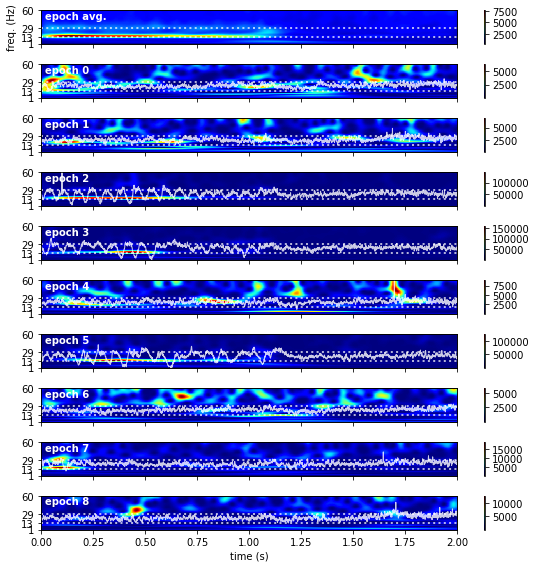

In [101]:
example_trials = [0,1,2,3,4,5,6,7,8]

fig = se.plot_avg_spectrogram(tfr=tfrs,
                              times=times,
                              freqs=freqs,
                              event_band=event_band,
                              timeseries=lfp_data,
                              example_epochs=example_trials,
                              figsize=(8,8))

In [12]:
spec_events = se.find_events(tfr=tfrs, times=times, freqs=freqs,
                             event_band=event_band, threshold_FOM=thresh_FOM)

In [20]:
event_df_list = list()
for trial_idx, trial_events in enumerate(spec_events):
    for event_idx, event_dict in enumerate(trial_events):
        event_dict['Trial'] = trial_idx
        event_dict['Rec Time'] = event_ts[trial_idx]
        event_df_list.append(event_dict)




In [21]:
event_df = pd.DataFrame(event_df_list)

In [171]:
power_threshold = 7_000
max_event_df = event_df.copy()
max_event_df = max_event_df[max_event_df['Peak Power'] < power_threshold]

max_event_df = max_event_df[max_event_df['Peak Time'] < 0.85]
max_event_df = max_event_df[max_event_df['Event Duration'] < 0.5]

max_event_df = max_event_df.groupby('Trial').max('Peak Power').reset_index()
#max_event_df = max_event_df[max_event_df['Normalized Peak Power'] < power_threshold]

In [172]:
max_event_df

,Trial,Peak Frequency,Lower Frequency Bound,Upper Frequency Bound,Frequency Span,Peak Time,Event Onset Time,Event Offset Time,Event Duration,Peak Power,Normalized Peak Power,Rec Time
0,0,14,11,40,29,0.055028,0.000000,0.214107,0.320160,4655.432570,6.803533,26.188833
1,1,18,15,23,8,0.618309,0.517259,0.697349,0.180090,6980.286379,8.264253,38.910633
2,3,26,22,30,8,0.181091,0.000000,0.240120,0.120060,6605.476254,8.247262,63.881800
3,4,19,16,23,8,0.218109,0.119060,0.395198,0.276138,6515.537645,7.584547,76.615667
4,5,28,22,37,15,0.042021,0.002001,0.500250,0.498249,6645.031398,8.250765,117.235333
...,...,...,...,...,...,...,...,...,...,...,...,...
88,205,18,15,22,7,0.762381,0.671336,0.838419,0.167084,6591.167483,7.803559,3936.309400
89,208,29,15,37,22,0.834417,0.798399,0.877439,0.079040,5243.662686,6.474231,3972.416067
90,212,21,13,26,13,0.523262,0.440220,0.624312,0.184092,5756.211883,7.558614,4034.514767
91,214,29,13,34,21,0.817409,0.759380,0.873437,0.114057,5731.145455,7.076114,4070.544433


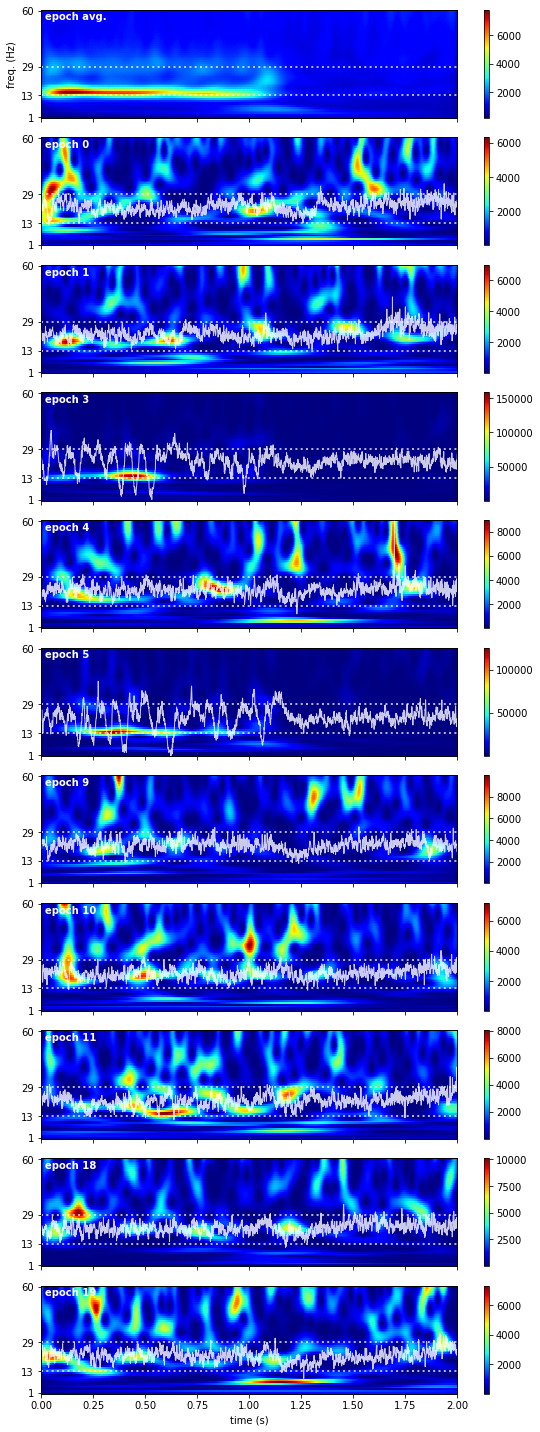

In [173]:
example_trials = max_event_df['Trial'].values[:10]

fig = se.plot_avg_spectrogram(tfr=tfrs,
                              times=times,
                              freqs=freqs,
                              event_band=event_band,
                              timeseries=lfp_data,
                              example_epochs=example_trials,
                              figsize=(8,20))

In [184]:
# Calculate the actual time the Beta Event peak occurs during the full recording session
max_event_times = max_event_df['Peak Time'].values + max_event_df['Rec Time'].values

#st_data = spike_train_functions.st_window_split(unit_timestamps_list, event_times=max_event_times * pq.s, wstart=-0.15 * pq.s, wstop=0.15 * pq.s)
st_data = spike_train_functions.st_window_split(unit_timestamps_list, event_times=gocON * pq.s, wstart=-0.5 * pq.s, wstop=0.5 * pq.s)

In [195]:
projection_args = {'n_components': 2, 'perplexity': 9, 'learning_rate': 5, 'random_state': 0}
st_args = (10,)
model = simnets.SIMNETS(st_dist='victor-purpura', unit_dist='correlation', projection='TSNE')
model.fit(st_data, st_args=st_args, projection_args=projection_args)


/home/ntolley/anaconda3/lib/python3.9/site-packages/numba/core/ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'unit_data' of function 'SIMNETS._make_trial_func.<locals>.TrialSimilarityMatrix'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../SIMNETS-Python/simnets/simnets_.py", line 139:
        @numba.njit()
        def TrialSimilarityMatrix(unit_data, st_args=None):
        ^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/home/ntolley/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


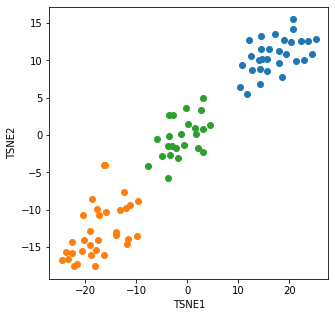

In [196]:
num_clusters = 3
cluster_pts = KMeans(n_clusters=num_clusters).fit_predict(model.points)

color_map = ['C0', 'C1', 'C2', 'C3', 'C4']
plt.figure(figsize=(5,5))
for cluster_idx in range(num_clusters):
    cluster_mask = cluster_pts == cluster_idx
    plt.scatter(model.points[cluster_mask, 0], model.points[cluster_mask, 1], color=color_map[cluster_idx])
    plt.xlabel('TSNE1')
    plt.ylabel('TSNE2')

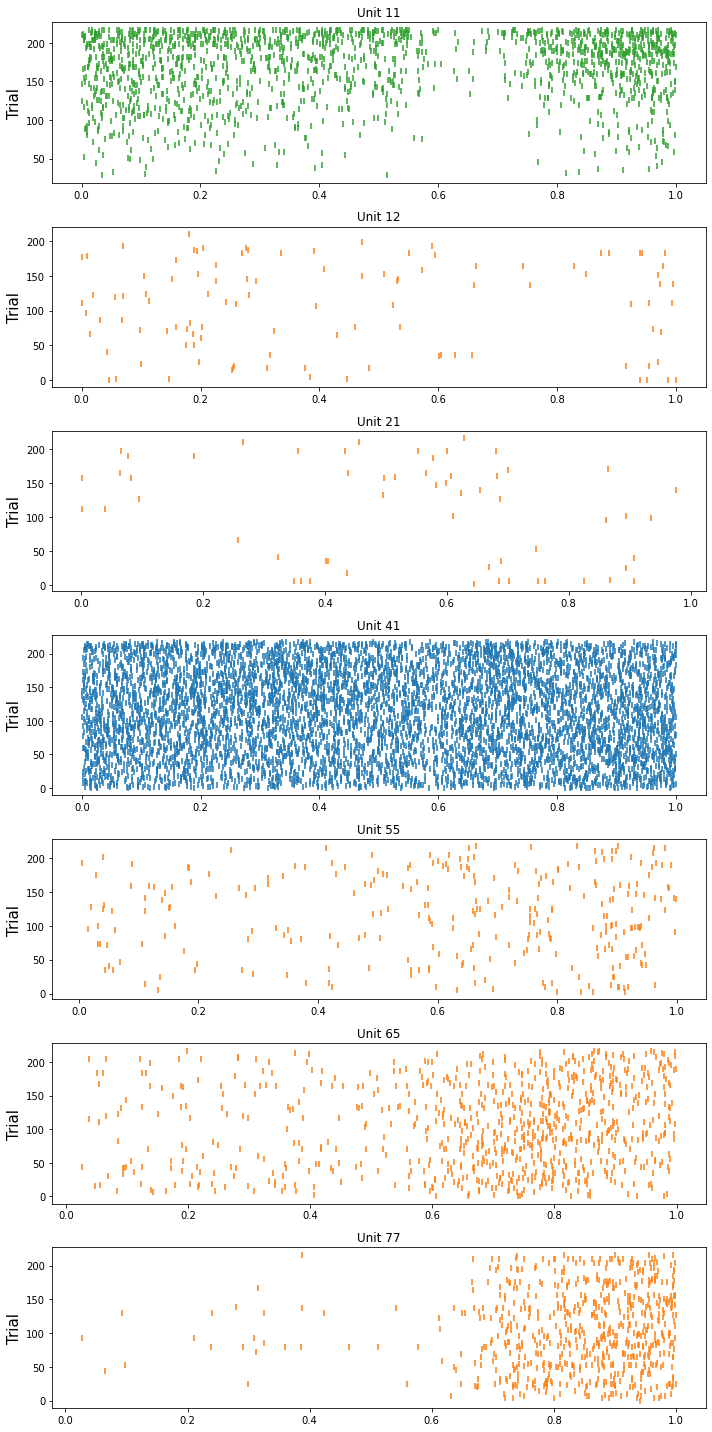

In [202]:
# Plot trials
plt.figure(figsize=(10,20))
for plot_idx, unit_idx in enumerate([11,12,21,41,55,65,77]):
    if plot_idx == 0:
        counts = [len(unit_data) for unit_data in st_data[unit_idx]] 
        trial_order = np.argsort(counts)

    plt.subplot(7,1,plot_idx + 1)
    for trial_idx in range(len(st_data[unit_idx])):
        plot_trial = trial_order[trial_idx]
        plot_data = st_data[unit_idx][plot_trial]
        height_data = np.repeat(trial_idx, len(plot_data))
        plt.scatter(plot_data, height_data,color=color_map[cluster_pts[unit_idx]], marker='|')
    plt.ylabel('Trial', fontsize=15)
    plt.title(f'Unit {unit_idx}')
    plt.tight_layout()

    

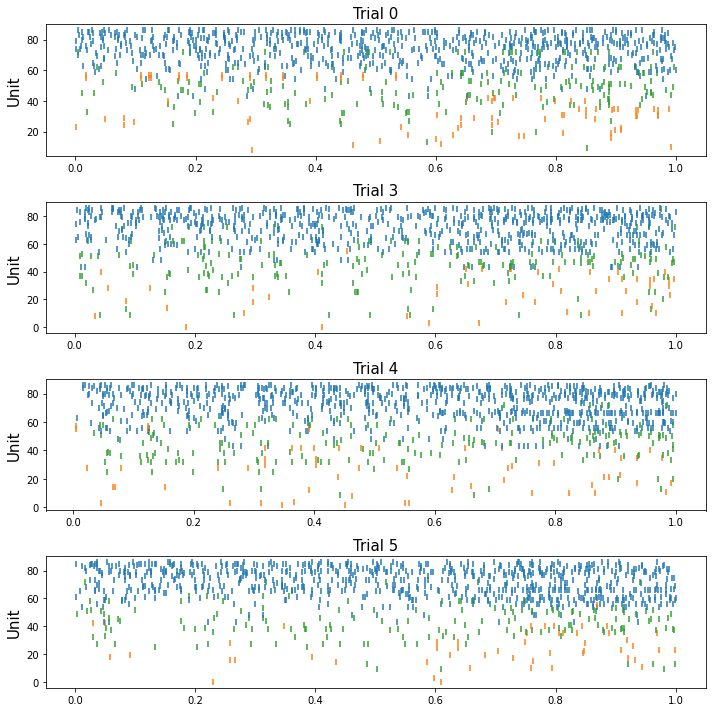

In [198]:
plt.figure(figsize=(10,10))
for plot_idx, trial_idx in enumerate([0, 2, 3, 4]):

    # Pull out spikes for specific trial across all neurons
    trial_data = [unit_data[trial_idx] for unit_data in st_data]
    
    if plot_idx == 0:
        counts = [len(unit_data) for unit_data in trial_data]
        unit_order = np.argsort(counts)

    plt.subplot(4,1, plot_idx + 1)
    for unit_idx in range(len(trial_data)):
        plot_unit = unit_order[unit_idx]
        plot_data = trial_data[plot_unit]
        height_data = np.repeat(unit_idx, len(plot_data))
        plt.scatter(plot_data, height_data,color=color_map[cluster_pts[plot_unit]], marker='|')
    
    plt.ylabel('Unit', fontsize=15)
    plt.title(f'Trial {max_event_df["Trial"].values[trial_idx]}', fontsize=15)

plt.tight_layout()

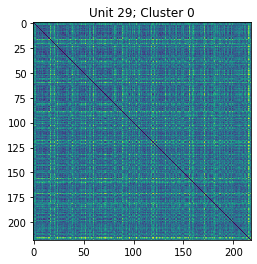

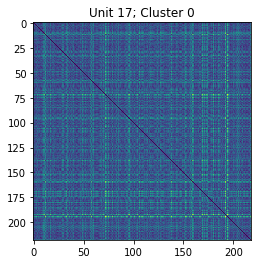

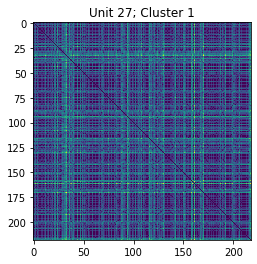

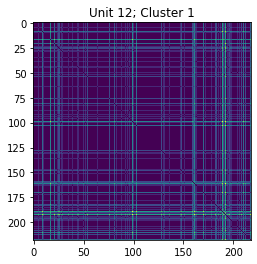

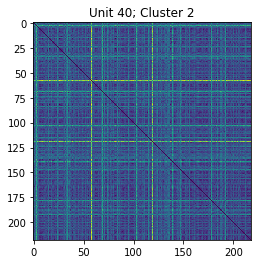

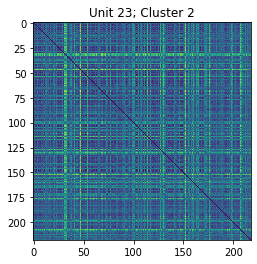

In [201]:
plot_units = [10, 5]

plot_clusters = [0, 1, 2]

unit_indices = list()
for cluster_idx in plot_clusters:
    for plot_unit in plot_units:
        cluster_units = np.where(cluster_pts == cluster_idx)[0]
        unit_idx = cluster_units[plot_unit]
        unit_indices.append(unit_idx)
        trial_sim = model.trial_sim[unit_idx].reshape(model.num_trials, model.num_trials)
        plt.figure()
        plt.imshow(trial_sim)
        plt.title(f'Unit {unit_idx}; Cluster {cluster_idx}')
       
